In [1]:
!git clone https://github.com/manmeet3591/download_oco3_carbon_sif

Cloning into 'download_oco3_carbon_sif'...
remote: Enumerating objects: 3341, done.
remote: Total 3341 (delta 0), reused 0 (delta 0), pack-reused 3341 (from 2)
Receiving objects: 100% (3341/3341), 682.83 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (5761/5761), done.


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.2 MB/s eta 0:00:00


In [9]:
!ls download_oco3_carbon_sif/GPPSIF/2022/GPP_20221217.tif

download_oco3_carbon_sif/GPPSIF/2022/GPP_20221217.tif


In [10]:
# Reassign the file path
tif_file = "download_oco3_carbon_sif/GPPSIF/2022/GPP_20221217.tif"
netcdf_file = "GPP_20221217.nc"

import rasterio
import numpy as np
import xarray as xr

# Read the TIFF file
with rasterio.open(tif_file) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile  # Get metadata
    transform = src.transform  # Get transform information
    crs = src.crs  # Get coordinate reference system

# Create coordinate values
height, width = data.shape
x = np.linspace(transform.c, transform.c + transform.a * width, width)
y = np.linspace(transform.f, transform.f + transform.e * height, height)

# Create an xarray dataset
ds_xr = xr.Dataset(
    {
        "GPP": (["y", "x"], data)
    },
    coords={
        "x": x,
        "y": y
    }
)

# Save as NetCDF
ds_xr.to_netcdf(netcdf_file)

# Load the NetCDF file using xarray
ds_netcdf = xr.open_dataset(netcdf_file)

# Display the dataset structure
ds_netcdf

<xarray.Dataset> Size: 814kB
Dimensions:  (x: 720, y: 280)
Coordinates:
  * x        (x) float64 6kB -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * y        (y) float64 2kB 80.0 79.5 79.0 78.49 ... -58.49 -59.0 -59.5 -60.0
Data variables:
    GPP      (y, x) float32 806kB ...

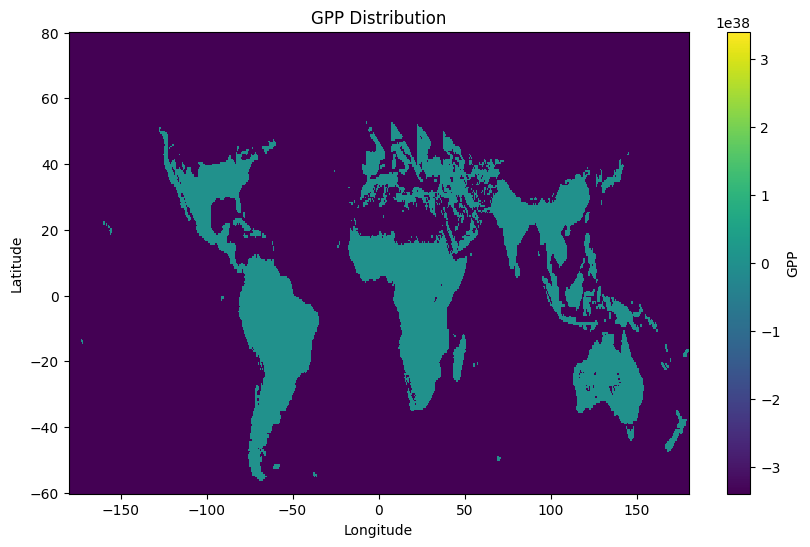

In [11]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
ds_netcdf["GPP"].plot(cmap="viridis")
plt.title("GPP Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


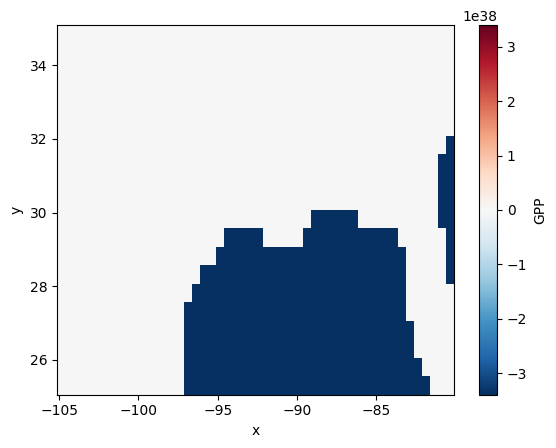

In [20]:
ds_netcdf.GPP.sel(y=slice(35,25), x=slice(-105, -80)).plot()

In [21]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 87.4 MB/s eta 0:00:00


<ipython-input-23-374fc6541b2f>:47: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


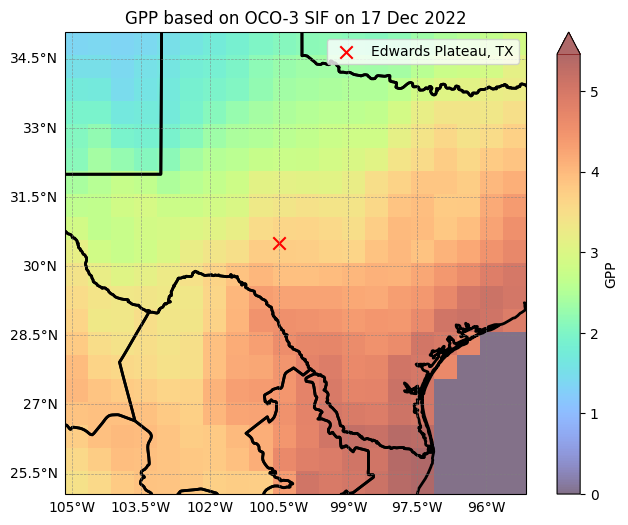

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

# Create the figure and axis with cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with transparency
ds_netcdf.GPP.sel(y=slice(35,25), x=slice(-105, -95)).plot(
    cmap='turbo', alpha=0.6, ax=ax, vmin=0, extend='max'
)

# Mark Edwards Plateau
edwards_plateau_coords = (360-100.5, 30.5)  # Approximate location
ax.scatter(*edwards_plateau_coords, color='red', marker='x', s=80, label="Edwards Plateau, TX")
# ✅ Fix: Load State Boundaries from Natural Earth Shapefile
# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1, edgecolor="black", label="Country Borders")

# ✅ Add ALL state boundaries (Including Texas)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.8, linestyle="-", label="State Boundaries")

# ✅ Manually highlight Texas state boundary (Thicker Line)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=2, linestyle="-", label="Texas Border")

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Corrected attributes for removing top and right labels
gl.top_labels = False  # Remove top longitude labels
gl.right_labels = False  # Remove right latitude labels

# Format longitude and latitude labels
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Titles and Labels
plt.title('GPP based on OCO-3 SIF on 17 Dec 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend
ax.legend()

# Show the final plot
plt.savefig('oco3.png', dpi=500)